In [3]:
import cv2
import pickle
import pandas as pd
import zipfile as zf
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
import os
import random
import gc

In [5]:
!pwd

/Users/olivialam/Desktop/safeGarbage


In [7]:
train_dir = "/Users/olivialam/Desktop/safeGarbage/train"
test_dir = "/Users/olivialam/Desktop/safeGarbage/test"

# get trash images from training set; useful if have to slice set if too large
train_trash = ["/Users/olivialam/Desktop/safeGarbage/train/{}".format(i) for i in os.listdir(train_dir) if 'trash' in i]
# get recyclable images from training set; same idea as above
train_cardboard = ["/Users/olivialam/Desktop/safeGarbage/train/{}".format(i) for i in os.listdir(train_dir) if 'cardboard' in i]
train_paper = ["/Users/olivialam/Desktop/safeGarbage/train/{}".format(i) for i in os.listdir(train_dir) if 'paper' in i]
train_glass = ["/Users/olivialam/Desktop/safeGarbage/train/{}".format(i) for i in os.listdir(train_dir) if 'glass' in i]
train_metal = ["/Users/olivialam/Desktop/safeGarbage/train/{}".format(i) for i in os.listdir(train_dir) if 'metal' in i]
train_plastic = ["/Users/olivialam/Desktop/safeGarbage/train/{}".format(i) for i in os.listdir(train_dir) if 'plastic' in i]

train_recycle = train_cardboard + train_paper + train_glass + train_metal + train_plastic

# get test images
test_imgs = ["/Users/olivialam/Desktop/safeGarbage/test/{}".format(i) for i in os.listdir(test_dir)]
random.shuffle(test_imgs)

# combine training images and scramble
train_imgs = train_trash + train_recycle[:150]
random.shuffle(train_imgs)


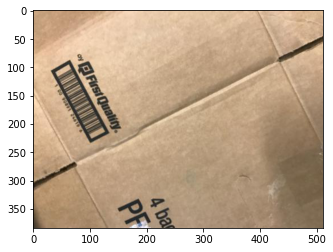

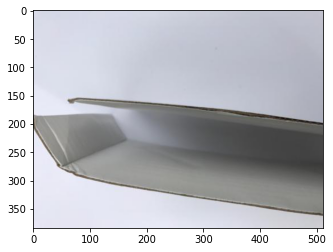

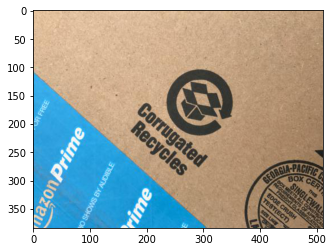

In [8]:
# check for proper scramble
import matplotlib.image as mpimg
for ima in train_imgs[0:3]:
    img=mpimg.imread(ima)
    imgplot = plt.imshow(img)
    plt.show()

In [9]:
nrows = 384
ncolumns = 512
channels = 3 # if greyscale = 1

In [10]:
# function to read images; classify trash as 0 and recyclable as 1

def read_and_process_image(list_of_images):
    
    X = [] # images
    y = [] # labels
    
    for image in list_of_images:
        X.append(cv2.resize(cv2.imread(image, cv2.IMREAD_COLOR), (nrows,ncolumns), interpolation=cv2.INTER_CUBIC))
        if "trash" in image:
            y.append(0)
        else:
            y.append(1)
            
    return X,y

In [11]:
X,y = read_and_process_image(train_imgs)

In [12]:
X[:5]

[array([[[136, 172, 208],
         [132, 168, 204],
         [129, 165, 201],
         ...,
         [156, 193, 227],
         [155, 192, 226],
         [150, 187, 221]],
 
        [[138, 174, 210],
         [133, 169, 205],
         [129, 165, 201],
         ...,
         [156, 193, 227],
         [154, 191, 225],
         [149, 186, 220]],
 
        [[139, 175, 211],
         [133, 169, 205],
         [127, 163, 199],
         ...,
         [155, 192, 226],
         [152, 189, 223],
         [148, 185, 219]],
 
        ...,
 
        [[ 49,  61,  69],
         [ 48,  60,  69],
         [ 49,  61,  71],
         ...,
         [ 82, 107, 127],
         [ 82, 107, 127],
         [ 82, 107, 127]],
 
        [[ 50,  61,  69],
         [ 49,  60,  69],
         [ 49,  61,  70],
         ...,
         [ 82, 107, 127],
         [ 82, 107, 127],
         [ 82, 107, 127]],
 
        [[ 50,  61,  69],
         [ 49,  60,  69],
         [ 49,  61,  71],
         ...,
         [ 82, 107, 127],
  

In [13]:
y[:5]

[1, 1, 1, 1, 0]

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:4: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  after removing the cwd from sys.path.


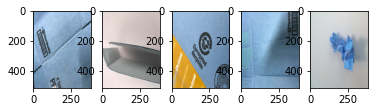

In [14]:
plt.figuresize=(50,50)
columns = 5
for i in range(columns):
    plt.subplot(5 / columns + 1, columns, i + 1)
    plt.imshow(X[i])

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, 'Labels for trash and recyclables')

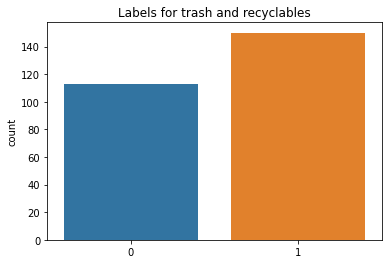

In [15]:
import seaborn as sb

# convert lists to numpy array
X = np.array(X)
y = np.array(y)
sb.countplot(y)
plt.title('Labels for trash and recyclables')

# plots counts of how many of trash vs non recyclables there are (ours is very disproportionate)

In [16]:
print("Shape of train image is:", X.shape)
print("Shape of labels is:", y.shape)

Shape of train image is: (263, 512, 384, 3)
Shape of labels is: (263,)


In [17]:
# split data into train and validation set
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.20, random_state=2)

print("Shape of train images is:", X_train.shape)
print("Shape of validation images is:", X_val.shape)
print("Shape of labels is:", y_train.shape)
print("Shape of labels is:", y_val.shape)

Shape of train images is: (210, 512, 384, 3)
Shape of validation images is: (53, 512, 384, 3)
Shape of labels is: (210,)
Shape of labels is: (53,)


In [18]:
# get length of train and validation data
ntrain = len(X_train)
nval = len(X_val)

# Batch size of 2^5
batch_size = 16

In [19]:
# time to build CNN!

from keras import layers
from keras import models
from keras import optimizers
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import img_to_array, load_img

In [20]:
model = models.Sequential()
model.add(layers.Conv2D(32,(3,3), activation = 'relu', input_shape=(384,512,3)))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(64, (3,3), activation='relu'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(128,(3,3), activation='relu'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(128, (3,3), activation='relu'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 382, 510, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 191, 255, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 189, 253, 64)      18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 94, 126, 64)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 92, 124, 128)      73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 46, 62, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 44, 60, 128)       1

In [21]:
# compile model with RMS optimizer, learning rate 0.0001; binary crossentropy bc binary classification
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])

In [22]:
# create augmentation configuration, using ImageDataGenerator to:
# 1. decode JPEG to RGB pixels
# 2. Convert these into floating-point tensors
# 3. Rescale pixel values between (0,255) to normalized values between [0,1]
# prevents overfitting bc we have a small n size

train_datagen = ImageDataGenerator(rescale=1./255, # scale img between [0,1] -> values will have mean = 0 and SD = 1
                                   rotation_range = 40,   # the rest of these params augment dataset images to improve generalization                               
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,)

val_datagen = ImageDataGenerator(rescale=1./255) # do not augment validation data, only rescale (bc we are testing our model on these)

In [23]:
# create image generators using above ImageDataGenerators
train_generator = train_datagen.flow(X_train, y_train, batch_size=batch_size)
val_generator = val_datagen.flow(X_val, y_val, batch_size=batch_size)


In [24]:
# training
history = model.fit(train_generator,
                             steps_per_epoch=ntrain // batch_size,
                             epochs=48, # epoch is a full cycle through entire training set
                             validation_data=val_generator,
                             validation_steps=nval // batch_size)

Epoch 1/48
13/13 [==============================] - 41s 3s/step - loss: 1.2182 - acc: 0.5619 - val_loss: 0.6261 - val_acc: 0.6667
Epoch 2/48
13/13 [==============================] - 44s 3s/step - loss: 0.6957 - acc: 0.5309 - val_loss: 0.6684 - val_acc: 0.6667
Epoch 3/48
13/13 [==============================] - 44s 3s/step - loss: 0.6883 - acc: 0.5464 - val_loss: 0.6811 - val_acc: 0.7292
Epoch 4/48
13/13 [==============================] - 43s 3s/step - loss: 0.6699 - acc: 0.6392 - val_loss: 0.6757 - val_acc: 0.4583
Epoch 5/48
13/13 [==============================] - 45s 3s/step - loss: 0.6993 - acc: 0.5515 - val_loss: 0.6548 - val_acc: 0.6875
Epoch 6/48
13/13 [==============================] - 57s 4s/step - loss: 0.6605 - acc: 0.5979 - val_loss: 0.5810 - val_acc: 0.7292
Epoch 7/48
13/13 [==============================] - 50s 4s/step - loss: 0.6318 - acc: 0.6495 - val_loss: 0.6022 - val_acc: 0.7083
Epoch 8/48
13/13 [==============================] - 63s 5s/step - loss: 0.6231 - acc: 0.70

In [25]:
# save the model; has accuracy of ~70% lol
model.save_weights('model_weights.h5')
model.save('model_keras.h5')

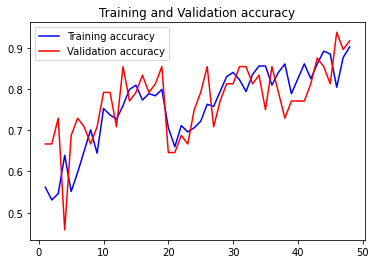

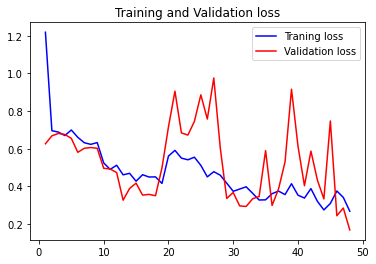

In [26]:
# plot train and val curve
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# train and validation accuracy
plt.plot(epochs, acc, 'b', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and Validation accuracy')
plt.legend()

plt.figure()

# train and validation loss
plt.plot(epochs, loss, 'b', label='Traning loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()

plt.show()

In [27]:
# now predict on first 10 imgs of test set
X_test, y_test = read_and_process_image(test_imgs[0:10]) # y_test in this case will be empty
x = np.array(X_test)
test_datagen = ImageDataGenerator(rescale=1./255)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:10: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  # Remove the CWD from sys.path while we load stuff.


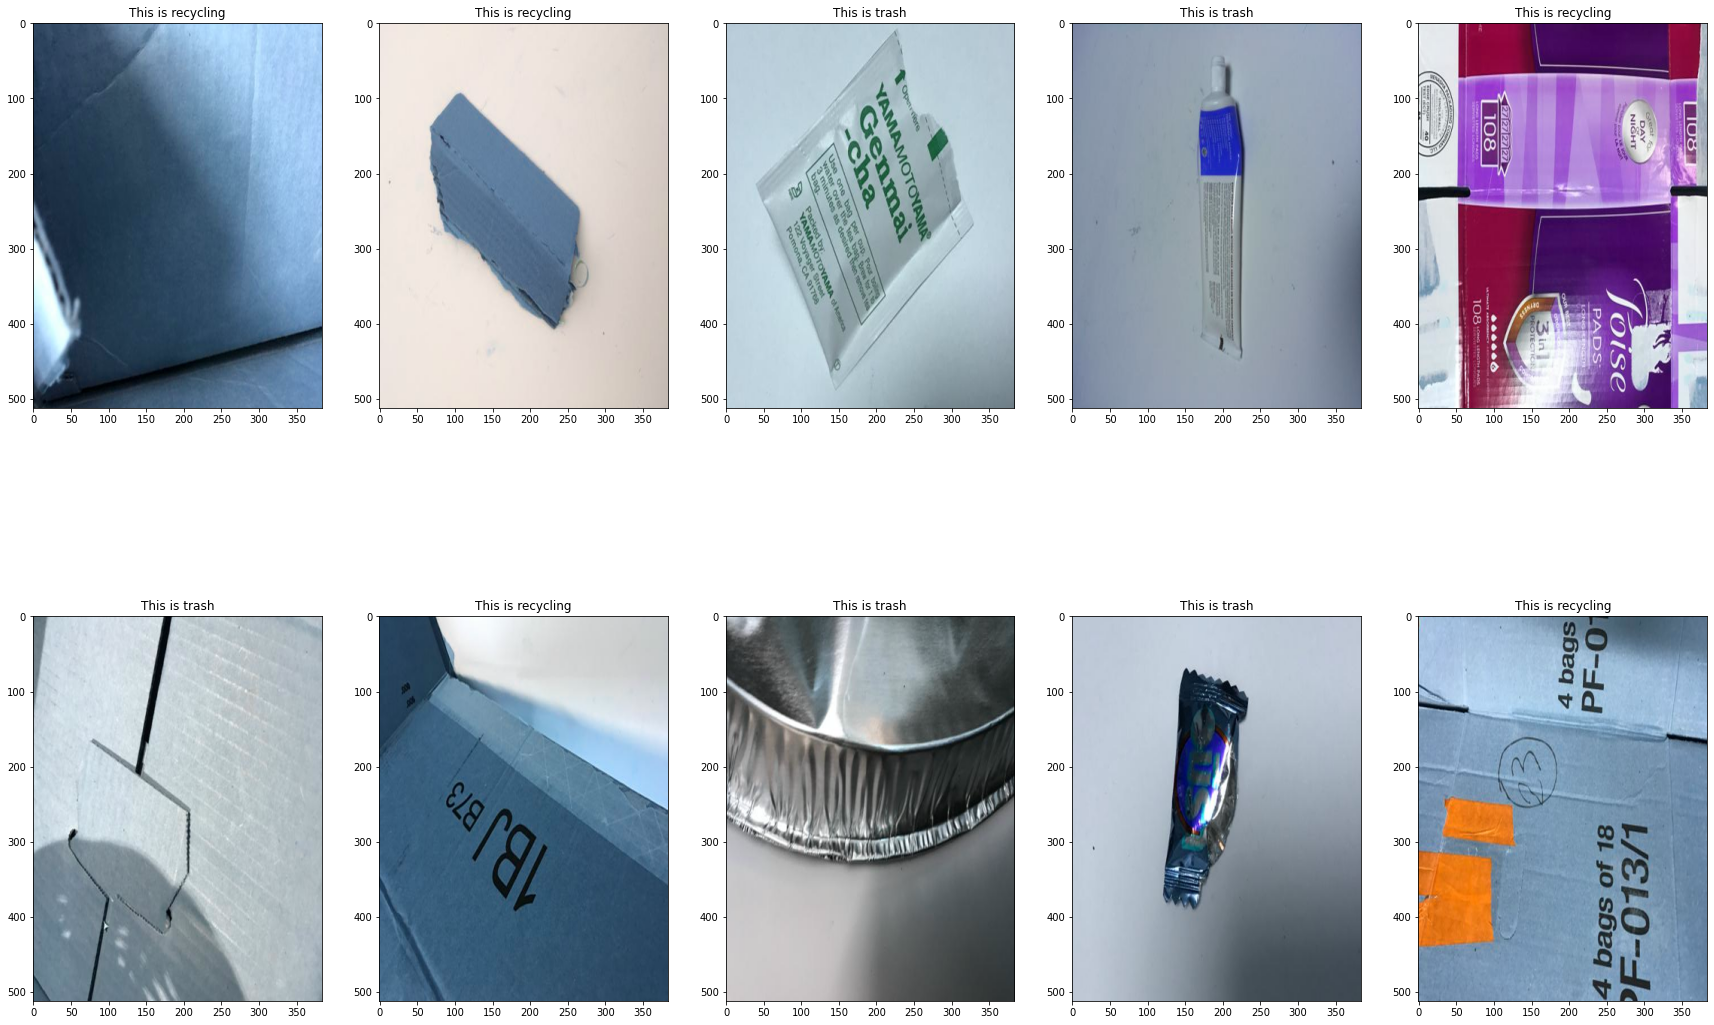

In [28]:
i = 0
text_labels = []
plt.figure(figsize=(30,20))
for batch in test_datagen.flow(x, batch_size=1):
    pred = model.predict(batch)
    if pred > 0.5:
        text_labels.append('recycling')
    else:
        text_labels.append('trash')
    plt.subplot(5 / columns + 1, columns, i + 1)
    plt.title('This is ' + text_labels[i])
    imgplot = plt.imshow(batch[0])
    i += 1
    if i % 10 == 0:
        break

plt.show()
    


In [ ]:
import tensorflowjs as tfjs
tfjs.converters.save_keras_model(model, '/Users/olivialam/Desktop/safeGarbage')